# Model 1: predicting traffic accident severity with structured data

## Importing the libraries and data

In [192]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import itertools

In [222]:
accidents = pd.read_csv('data/accidents/London_accidents_merged.csv')

In [223]:
accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


## Preparing the data for modelling

In [224]:
# Adding a column for month
accidents['Month'] = pd.to_datetime(accidents['Date']).dt.month_name()

In [225]:
# Dropping unnecessary columns
accidents.drop(['Accident_Index', 'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Hour', 'Time_of_Day', 'log_Number_of_Casualties', 'log_Number_of_Vehicles', 'LSOA', 'Road', 'RCat'], axis=1, inplace=True)

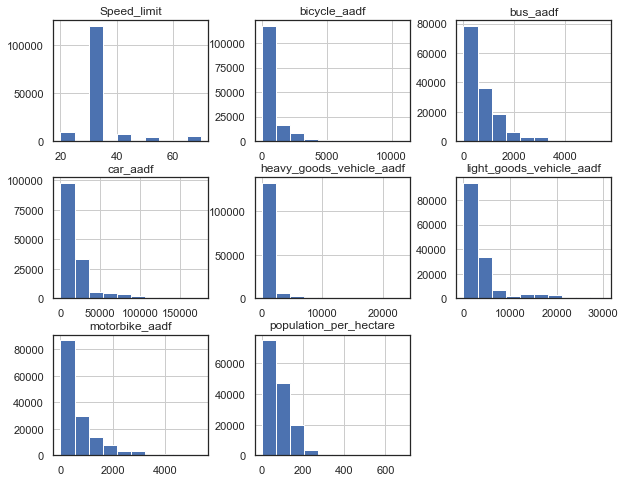

In [226]:
# Checking whether numerical columns need log transforming
accidents.hist(figsize=(10,8));

In [227]:
# Log-transforming traffic and population counts due to positive skew
# Creating list of columns to transform
to_log_transform = list(accidents.columns[accidents.columns.str.endswith('aadf') == True])
to_log_transform.append('population_per_hectare')

# Replacing 0s with 0.1s to allow for log transformation
accidents[to_log_transform] = accidents[to_log_transform].replace(0, 0.1)

# Adding log transformed columns and dropping original columns
for col in to_log_transform:
    log_col = "log_"+col
    accidents[log_col] = np.log(accidents[col])
    accidents.drop(col, axis=1, inplace=True)

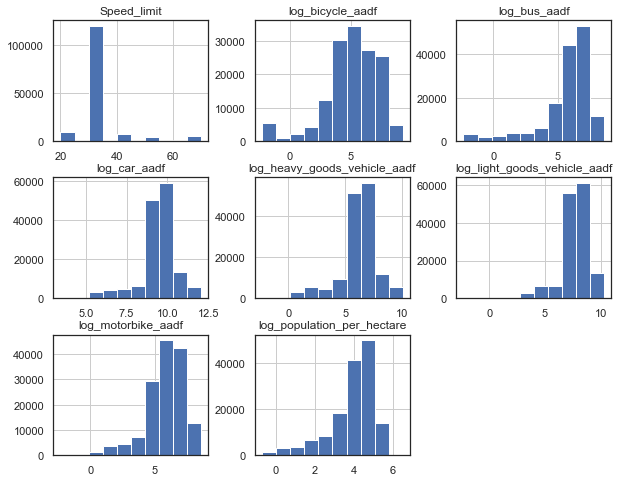

In [228]:
# Confirming that distributions are now more normal
accidents.hist(figsize=(10,8));

In [229]:
# Converting the target variable into numeric categories
accidents['Accident_Severity'].replace({'Slight': 1, 'Serious': 2, 'Fatal': 3}, inplace=True)
accidents['Accident_Severity'] = accidents['Accident_Severity'].astype('int64')

In [230]:
# One-hot encoding categorical variables
transformed_df = pd.get_dummies(accidents)

# Dropping one column for each of the one-hot encoded variables with two categories
transformed_df.drop(['Was_Daylight_No', 'Was_Bad_Weather_No', 'Was_Road_Dry_No', 'Urban_or_Rural_Area_Rural'], axis=1, inplace=True)

In [231]:
def multi_collinearity_heatmap(df, figsize=(11,9), annot=False):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot=annot, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

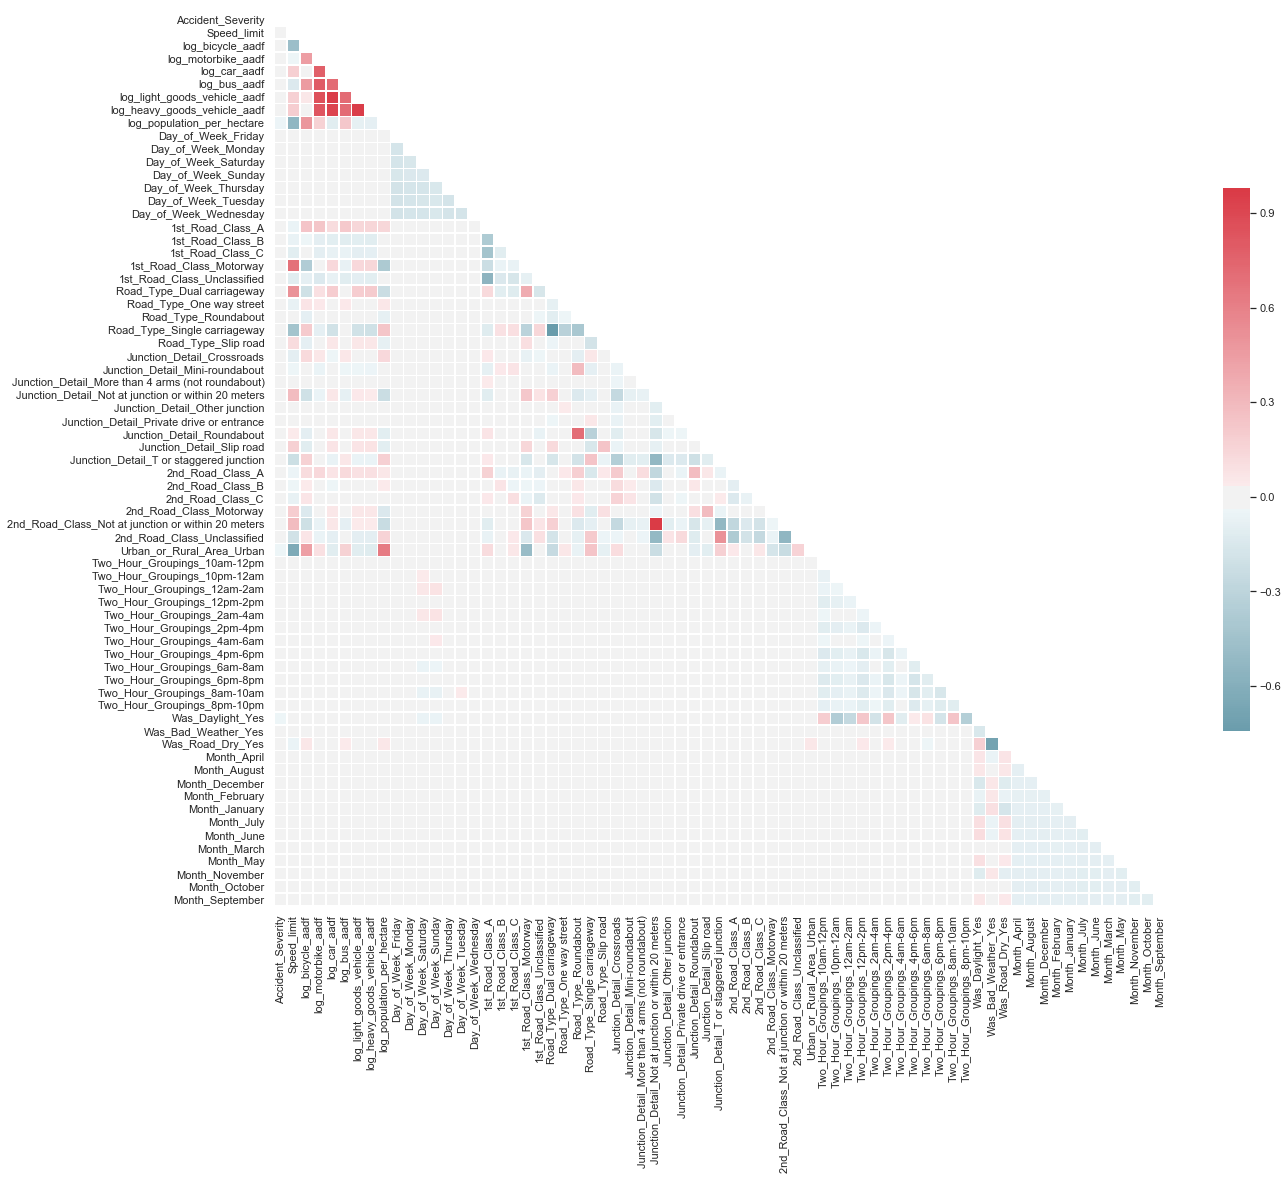

In [232]:
# Checking for multi-collinearity
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

Other columns to be dropped based on the multi-collinearity heatmap above:
- No junction within 20 metres is recorded under both '2nd_Road_Class' and 'Junction_Detail', so one will be dropped
- Roundabouts are recorded under both 'Road_Type' and 'Junction_Detail', so one will be dropped
- There is high correlation between traffic counts of motorbikes, cars, buses, light goods vehicles and heavy goods vehicles, so these can be combined into one feature

In [233]:
# Dropping columns
transformed_df.drop(['2nd_Road_Class_Not at junction or within 20 meters', 'Road_Type_Roundabout'], axis=1, inplace=True)

In [234]:
# Combining columns by undoing the log transformation, summing and then re-doing it
transformed_df['log_motor_vehicle_aadf'] = np.log(np.exp(transformed_df['log_motorbike_aadf'])
    + np.exp(transformed_df['log_car_aadf'])
    + np.exp(transformed_df['log_bus_aadf'])
    + np.exp(transformed_df['log_light_goods_vehicle_aadf'])
    + np.exp(transformed_df['log_heavy_goods_vehicle_aadf']))

In [235]:
# Dropping the columns that have now been combined
transformed_df.drop(['log_motorbike_aadf', 'log_car_aadf', 'log_bus_aadf', 'log_light_goods_vehicle_aadf', 'log_heavy_goods_vehicle_aadf'], axis=1, inplace=True)

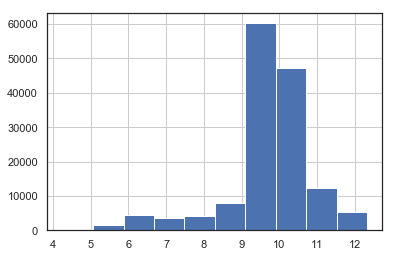

In [236]:
# Checking that the new column is roughly normally distributed
transformed_df.log_motor_vehicle_aadf.hist();

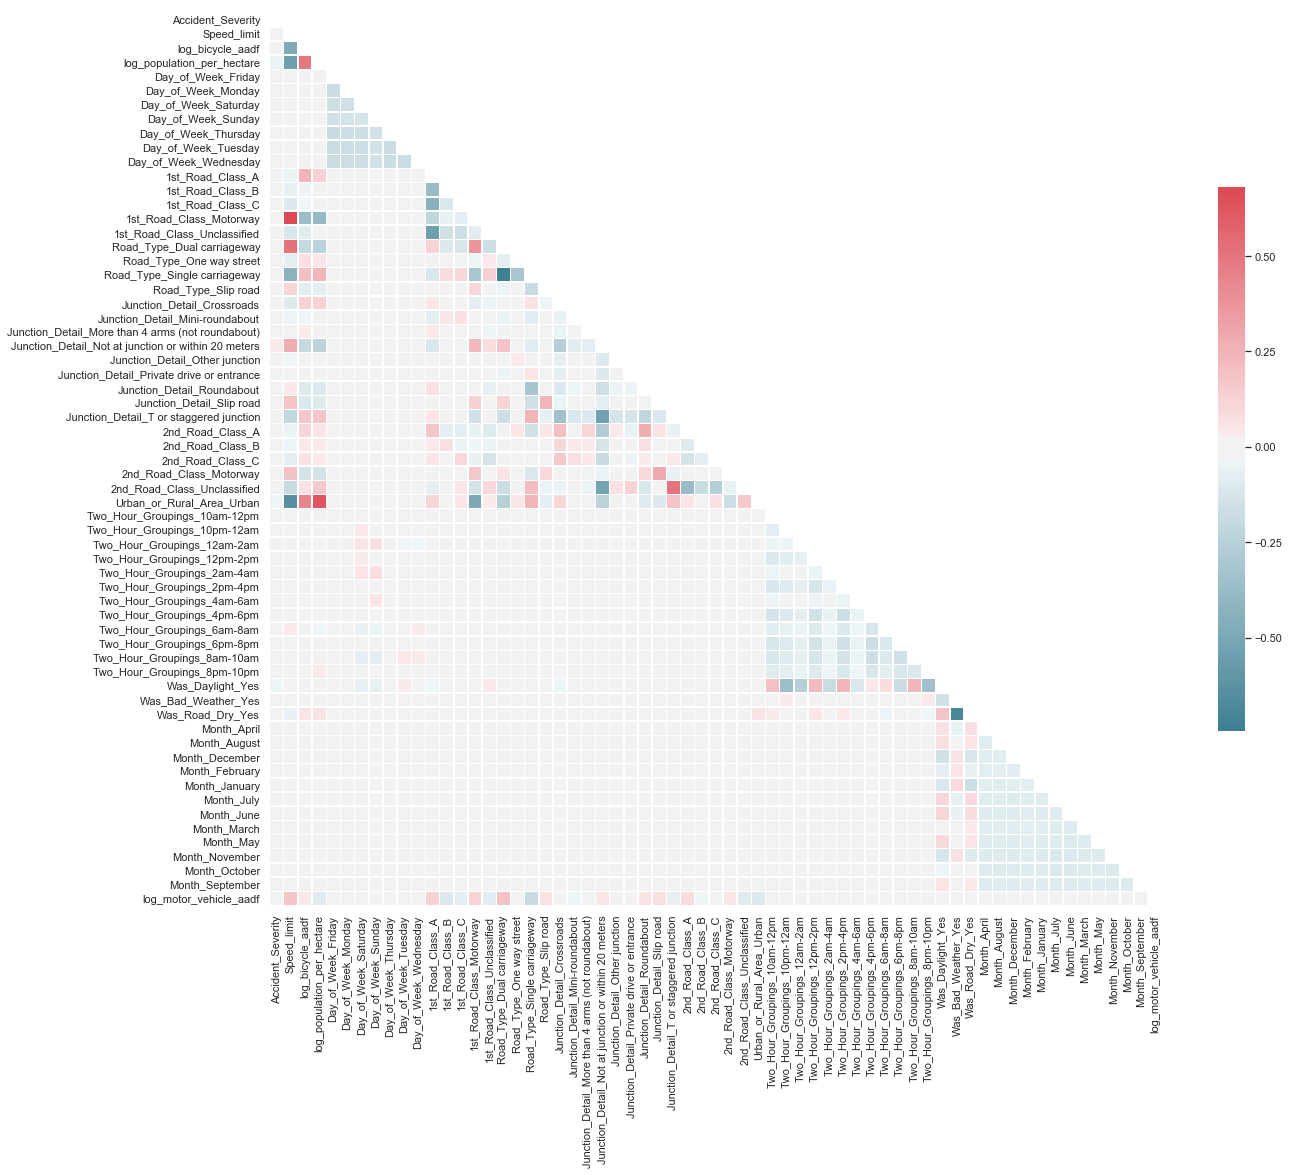

In [237]:
# Final check for multi-collinearity
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

A few notable correlations remain which make sense, e.g. a negative correlation between bad weather and dry roads, and positive correlations between urban areas and high population density, and motorways and speed limits. These could potentially be removed in later iterations of the model, but the correlations are not too high to require removal.

In [238]:
# Separating X and y
X_unscaled = transformed_df.drop('Accident_Severity', axis=1)
y = transformed_df['Accident_Severity']

# Scaling X using StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
X.head()

C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_A,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_Dual carriageway,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Crossroads,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,...,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.245006,1.039158,0.666034,-0.439762,-0.404311,-0.387455,-0.346933,-0.426712,-0.423379,2.348771,0.830989,-0.314446,-0.359667,-0.181921,-0.45564,-0.430502,-0.185088,0.578949,-0.109477,-0.415118,-0.131974,-0.119093,-0.630987,-0.158801,-0.161657,...,-0.345689,-0.127998,-0.37916,-0.122654,-0.428847,-0.270649,-0.405323,2.658917,-0.290034,0.655611,-0.385433,0.491062,-0.289992,-0.2923,-0.297246,-0.276819,3.439063,-0.317141,-0.308695,-0.293012,-0.303848,-0.321317,-0.31946,-0.305247,0.160787
1,-0.245006,0.563907,0.331528,2.273956,-0.404311,-0.387455,-0.346933,-0.426712,-0.423379,-0.425755,0.830989,-0.314446,-0.359667,-0.181921,-0.45564,-0.430502,-0.185088,0.578949,-0.109477,2.408955,-0.131974,-0.119093,-0.630987,-0.158801,-0.161657,...,-0.345689,-0.127998,-0.37916,-0.122654,-0.428847,-0.270649,-0.405323,2.658917,-0.290034,0.655611,2.594485,0.491062,-0.289992,-0.2923,-0.297246,-0.276819,3.439063,-0.317141,-0.308695,-0.293012,-0.303848,-0.321317,-0.31946,-0.305247,0.693932
2,-0.245006,-1.817963,0.822998,-0.439762,2.473346,-0.387455,-0.346933,-0.426712,-0.423379,-0.425755,-1.203386,3.180195,-0.359667,-0.181921,-0.45564,-0.430502,-0.185088,0.578949,-0.109477,2.408955,-0.131974,-0.119093,-0.630987,-0.158801,-0.161657,...,-0.345689,-0.127998,-0.37916,-0.122654,-0.428847,-0.270649,-0.405323,-0.376093,-0.290034,0.655611,-0.385433,0.491062,-0.289992,-0.2923,-0.297246,-0.276819,3.439063,-0.317141,-0.308695,-0.293012,-0.303848,-0.321317,-0.31946,-0.305247,1.440590
3,-0.245006,-1.817963,1.072576,-0.439762,-0.404311,-0.387455,-0.346933,2.343499,-0.423379,-0.425755,-1.203386,3.180195,-0.359667,-0.181921,-0.45564,-0.430502,-0.185088,0.578949,-0.109477,2.408955,-0.131974,-0.119093,-0.630987,-0.158801,-0.161657,...,-0.345689,-0.127998,-0.37916,-0.122654,-0.428847,-0.270649,-0.405323,-0.376093,-0.290034,0.655611,-0.385433,0.491062,-0.289992,-0.2923,-0.297246,-0.276819,3.439063,-0.317141,-0.308695,-0.293012,-0.303848,-0.321317,-0.31946,-0.305247,1.440590
4,-0.245006,0.759163,1.426376,2.273956,-0.404311,-0.387455,-0.346933,-0.426712,-0.423379,-0.425755,0.830989,-0.314446,-0.359667,-0.181921,-0.45564,-0.430502,5.402840,-1.727267,-0.109477,-0.415118,-0.131974,-0.119093,-0.630987,-0.158801,-0.161657,...,-0.345689,-0.127998,-0.37916,-0.122654,2.331831,-0.270649,-0.405323,-0.376093,-0.290034,-1.525295,-0.385433,0.491062,-0.289992,-0.2923,-0.297246,-0.276819,3.439063,-0.317141,-0.308695,-0.293012,-0.303848,-0.321317,-0.31946,-0.305247,0.495166


## Modelling

### Model iteration 1: vanilla Random Forests

In [239]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [240]:
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)

C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [242]:
print("Train:", rf1.score(X_train, y_train))
print("Test:", rf1.score(X_test, y_test))

rf1_y_preds_train = rf1.predict(X_train)
print(classification_report(y_train, rf1_y_preds_train))

rf1_y_preds_test = rf1.predict(X_test)
print(classification_report(y_test, rf1_y_preds_test))

Train: 0.9786975597374814
Test: 0.8904359176569766
              precision    recall  f1-score   support

           1       0.98      1.00      0.99     98709
           2       1.00      0.80      0.89     10993
           3       1.00      0.83      0.90       614

   micro avg       0.98      0.98      0.98    110316
   macro avg       0.99      0.87      0.93    110316
weighted avg       0.98      0.98      0.98    110316

              precision    recall  f1-score   support

           1       0.89      1.00      0.94     32836
           2       0.13      0.00      0.01      3741
           3       0.00      0.00      0.00       196

   micro avg       0.89      0.89      0.89     36773
   macro avg       0.34      0.33      0.32     36773
weighted avg       0.81      0.89      0.84     36773



This model appears to be performing well at first glance, but in fact is performing very poorly at predicting serious and fatal accidents (which also explains the overfitting). This is because of class imbalances. The next model will try to correct the class imbalances using SMOTE.

### Model iteration 2: Random Forests with SMOTE

In [243]:
print(y.value_counts()) # Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) # Preview synthetic sample class distribution

1    131545
2     14734
3       810
Name: Accident_Severity, dtype: int64
3    131545
2    131545
1    131545
dtype: int64


In [244]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [245]:
rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)

C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [246]:
print("Train:", rf2.score(X_train, y_train))
print("Test:", rf2.score(X_test, y_test))

rf2_y_preds_train = rf2.predict(X_train)
print(classification_report(y_train, rf2_y_preds_train))

rf2_y_preds_test = rf2.predict(X_test)
print(classification_report(y_test, rf2_y_preds_test))

Train: 0.9959287239505906
Test: 0.9485601921770949
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     98603
           2       1.00      0.99      0.99     98647
           3       1.00      1.00      1.00     98726

   micro avg       1.00      1.00      1.00    295976
   macro avg       1.00      1.00      1.00    295976
weighted avg       1.00      1.00      1.00    295976

              precision    recall  f1-score   support

           1       0.89      0.97      0.93     32942
           2       0.97      0.88      0.92     32898
           3       1.00      0.99      0.99     32819

   micro avg       0.95      0.95      0.95     98659
   macro avg       0.95      0.95      0.95     98659
weighted avg       0.95      0.95      0.95     98659



This model performs much better. It has a much higher success rate at predicting each class, with a test set F1 score for each class of 0.92-0.99. It has also greatly reduced the overfitting.

The confusion matrix below shows that the model's main issue is with incorrectly predicting serious accidents as only being slight.

In [247]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

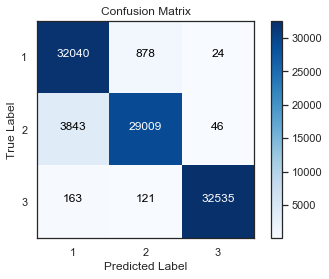

In [248]:
plot_cf(y_test, rf2_y_preds_test)

The graph of feature importances below show that:
- The biggest predictor of accident severity is the AADF (Annual Average Daily Flow) of motor vehicles on or near that road (including motorbikes, cars, buses, vans and trucks of different sizes)
- Population density and the AADF of bicycles are also important
- Speed limit, day/night and A roads are the next most important features
- Day of the week is more important than time of day or month

In [251]:
def plot_feature_importances(model, figsize=(6,14)):
    """Plots a graph of feature importances for a model"""
    ft_weights = pd.DataFrame(model.feature_importances_, columns=['weight'], index=X.columns)
    ft_weights.sort_values('weight', inplace=True)
    plt.figure(figsize=(6,14))
    plt.barh(ft_weights.index, ft_weights.weight, align='center') 
    plt.title("Feature importances", fontsize=14)
    plt.xlabel("Feature importance")
    plt.margins(y=0.01)
    plt.show()

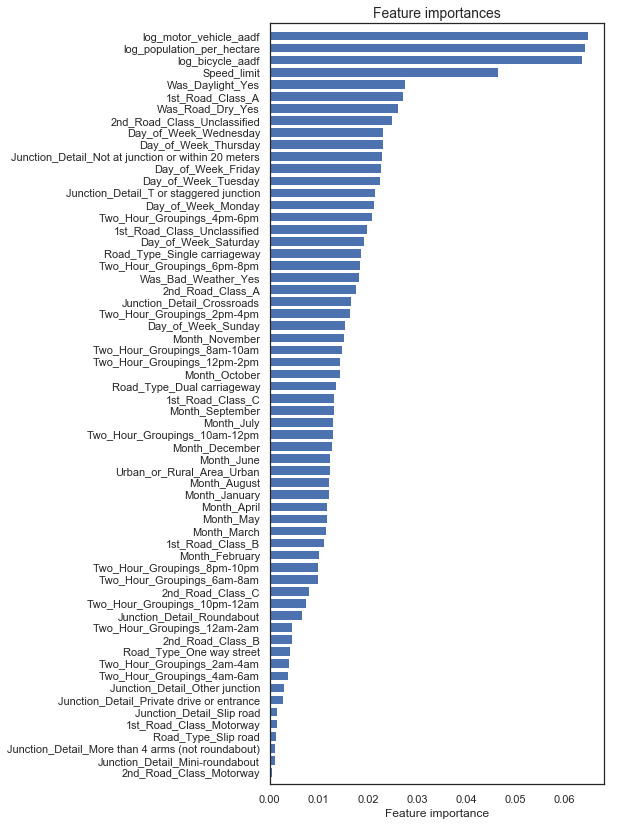

In [252]:
plot_feature_importances(rf2)

The results below show the direction of the impact of the top features. Slight and serious accidents tend to occur in relatively similar circumstances. Fatal accidents occur more frequently:
- on A roads (major roads, e.g. highways in the US)
- on roads with higher motor vehicle traffic and speed limits, and lower bicycle traffic
- in areas with lower population density
- at night
- on wet roads

In [276]:
for col in ['log_motor_vehicle_aadf', 'log_population_per_hectare', 'log_bicycle_aadf']:
    print(np.exp(transformed_df.groupby('Accident_Severity')[col].median()))
    print("")
    
for col in ['Speed_limit', 'Was_Daylight_Yes', '1st_Road_Class_A', 'Was_Road_Dry_Yes']:
    print(transformed_df.groupby('Accident_Severity')[col].mean())
    print("")

Accident_Severity
1    18274.800000
2    18011.000000
3    20186.435323
Name: log_motor_vehicle_aadf, dtype: float64

Accident_Severity
1    67.90000
2    61.54998
3    47.60000
Name: log_population_per_hectare, dtype: float64

Accident_Severity
1    185.600000
2    180.800000
3    128.599844
Name: log_bicycle_aadf, dtype: float64

Accident_Severity
1    32.252005
2    32.657798
3    35.901235
Name: Speed_limit, dtype: float64

Accident_Severity
1    0.704763
2    0.659020
3    0.560494
Name: Was_Daylight_Yes, dtype: float64

Accident_Severity
1    0.592657
2    0.578119
3    0.651852
Name: 1st_Road_Class_A, dtype: float64

Accident_Severity
1    0.806234
2    0.802158
3    0.785185
Name: Was_Road_Dry_Yes, dtype: float64

